In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, ConfusionMatrixDisplay



In [2]:
stop_words=stopwords.words('english')

In [3]:
real_news = pd.read_csv("True.csv")
fake_news = pd.read_csv("Fake.csv")
real_news['label'] = 1
fake_news['label'] = 0
df = pd.concat([real_news, fake_news], ignore_index=True)

In [4]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

In [5]:
def preprocess(text):
    if pd.isnull(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    words = text.strip().split()
    filtered = [stemmer.stem(word) for word in words if word not in stop_words]
    return " ".join(filtered)

In [6]:
df['title'] = df['title'].fillna('')
df['text'] = df['text'].fillna('')
df['text'] = df['title'] + ' ' + df['text']
df['text'] = df['text'].apply(preprocess)
df = df[df['text'].str.strip().astype(bool)]
df = df.reset_index(drop=True)


In [7]:
tfidf = TfidfVectorizer(max_features=5000, min_df=2)
X = tfidf.fit_transform(df['text'])
y = df['label'].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [9]:
def train_and_evaluate(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n {model_name} ")
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
    disp.plot(cmap="Blues", values_format='d')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()


 Decision Tree 
Accuracy:  0.9961024498886414
              precision    recall  f1-score   support

        Fake       1.00      0.99      1.00      4696
        Real       0.99      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



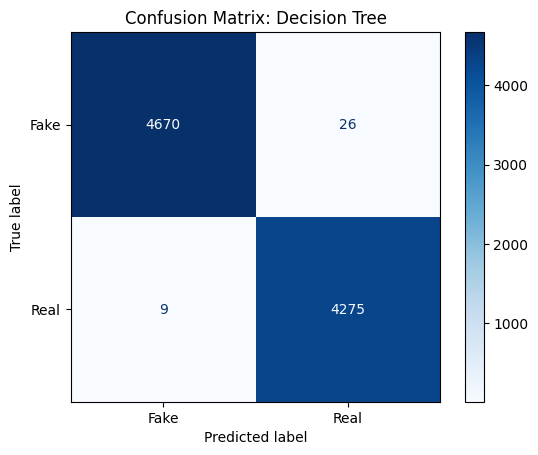

reuter: 0.9831
wiretv: 0.0026
imag: 0.0026
via: 0.0017
hillari: 0.0013
saidth: 0.0009
america: 0.0008
wire: 0.0006
factbox: 0.0004
flickr: 0.0004
trump: 0.0004
st: 0.0004
demograph: 0.0004
zika: 0.0003
thug: 0.0003
inform: 0.0003
wfb: 0.0003
said: 0.0003
last: 0.0003
sure: 0.0002


In [10]:
dt_params = {'max_depth': [5, 10, 15, 20]}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5)
dt_grid.fit(X_train, y_train)
feature_names = tfidf.get_feature_names_out()
importances = dt_grid.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 20  
top_words = [(feature_names[i], importances[i]) for i in indices[:top_n]]
for word, score in top_words:
    print(f"{word}: {score:.4f}")
train_and_evaluate(dt_grid.best_estimator_, "Decision Tree")


Top Fake Words
['via' 'video' 'imag' 'gop' 'hillari' 'wire' 'mr' 'break' 'america' 'rep'
 'even' 'american' 'sen' 'read' 'like' 'daili' 'isi' 'watch' 'entir'
 'saidth']
Top Real Words
['factbox' 'he' 'year' 'est' 'monday' 'london' 'comment' 'us' 'thursday'
 'edt' 'friday' 'dont' 'nov' 'tuesday' 'im' 'that' 'wednesday'
 'washington' 'said' 'reuter']

 Logistic Regression 
Accuracy:  0.9925389755011136
              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      4696
        Real       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



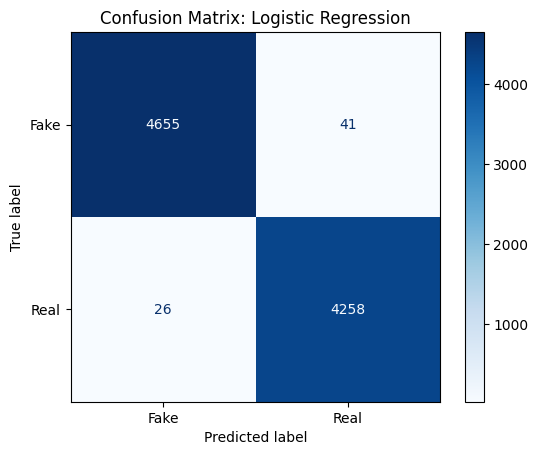

In [16]:
lr_params = {'C': [0.1, 1, 10]}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42), lr_params, cv=5)
lr_grid.fit(X_train, y_train)
feature_names = tfidf.get_feature_names_out() 
coefs = lr_grid.best_estimator_.coef_[0]

top_fake_indices = np.argsort(coefs)[:20]
top_fake_words = feature_names[top_fake_indices]
print("Top Fake Words")
print(top_fake_words)

top_real_indices = np.argsort(coefs)[-20:]
top_real_words = feature_names[top_real_indices]
print("Top Real Words")
print(top_real_words)
train_and_evaluate(lr_grid.best_estimator_, "Logistic Regression")



Top Fake words
['time' 'would' 'say' 'go' 'get' 'american' 'imag' 'state' 'donald'
 'republican' 'said' 'one' 'like' 'peopl' 'presid' 'hillari' 'obama'
 'clinton' 'video' 'trump']

 Naive Bayes 
Accuracy:  0.933630289532294
              precision    recall  f1-score   support

        Fake       0.93      0.94      0.94      4696
        Real       0.93      0.93      0.93      4284

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980



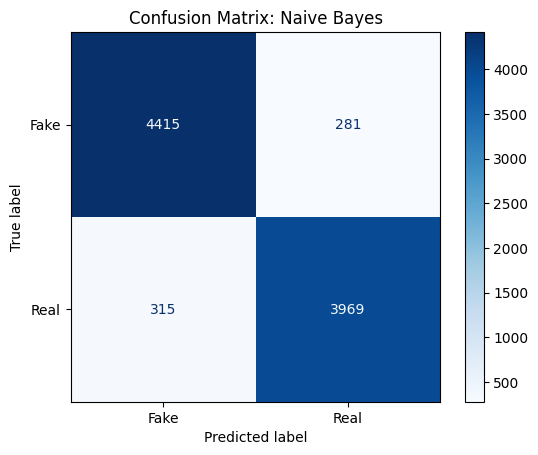

In [15]:
nb_params = {'alpha': [0.01, 0.1, 1.0]}
nb_grid = GridSearchCV(MultinomialNB(), nb_params, cv=5)
nb_grid.fit(X_train, y_train)
fake_class_index = list(nb_grid.best_estimator_.classes_).index(0) 
feature_log_probs = nb_grid.best_estimator_.feature_log_prob_

top_fake_words = feature_names[np.argsort(feature_log_probs[fake_class_index])[-20:]]
print("Top Fake words")
print(top_fake_words)
train_and_evaluate(nb_grid.best_estimator_, "Naive Bayes")
